# Derived allele frequencies and counts

Load global analysis variables:

In [18]:
%run standard.py

<Figure size 432x288 with 0 Axes>

## Moi's pipeline

- Checks the sites which any of the samples indicated (can include chimp or not) are different (SNP). If there is a sample with a different allele, then, it polarise the alleles in ancestral or derived allele depending on which outgroup you indicate (I use chimp, but we can use another as the ancestral allele inference from 1000GP).

- It outputs 3 files (similar strategy as the C-tools):
    - <filename>.geno: the genotypes for each individual (in columns) for each variable site (in rows). 0 means ancestral allele, 1 means derived allele and “.” means no information.
    - <filename>.snps: it corresponds to the position in the X chromosome. Each row corresponds to the rows in the geno file.
    - <filename>.inds: This file has listed the individuals used to check the variable sites. The order that they appear in this file, corresponds to the column-order in the geno file.
    
- Once we get those files, the pipeline runs a process that counts how many missing genotypes we have per each position (using the geno file). This file is named as <filename>.miss
- Finally, there is an script called sfs.py which you can define the following variables:
    - a dictionary for populations: name of the group of samples that you want to use to count the SFS and some other variables listed below. For instance, I defined Africans and NonAfricans
        - list with samples: this list indicates which samples belong to which group. Samples can be repeated in multiple populations
        - downsampling: This allows you to limit the sampling of alleles in each populations. Let’s say that you are comparing two populations: Africans, with 10 ind and nonAfricans with 100. Since comparing two SFSs from different populations with different sample size is complicated, it is good to downsample the population with more alleles to make a fare comparison of the counts.
    - minimum callability allowed: This defines a minimum callability in all the populations for a loci to be considered. If this variable is set to 0.8, it means that 80% of the individuals have to be called for a given position in both populations independently: 80% in Africans and 80% in NonAfricans. If the downsampling variable (explained above) is not defined, then, 80% of the alleles are going to be sampled, therefore, the downsample value must be less than this variable.
    - windowsize: This variable allows you to change the window size that you want to count the SFS for.

This script outputs a file (sfs.txt) which have the following information:
    
1. Population > which population the counts belong to
2. start > start position of the window
3. end > end position of the window
4. alleles with derived variant > (self explanatory)
5. counts > counts of the number of variants that certain number of individuals have the derived allele (field 4) ) in that given region (fields 2 and 3)) for that given population (field 1)).

Finally, I run two times my pipeline with different sets of variables:

1) Check sfs for variable sites only in humans, in two populations (Africans and NonAfricans), using Chimp to polarise the variant sites and check SFSs in 100kb windows. It has 508649 SNPs.

The outputs for this set of variables are in :

~/simons/faststorage/people/moi/X_chrom_Kasper/out/derived_alleles_pol_in_humans

2) Check sfs for variable sites comparing all the samples including Chimp, in two populations (Africans and NonAfricans, excluding Chimp), using Chimp to polarise the variant sites and check SFSs in 100kb windows. It has 1516667 SNPs (3 times more variants than the previous).

The outputs are in:

~/simons/faststorage/people/moi/X_chrom_Kasper/out/derived_alleles_pol_in_chimp_and_humans

When the variables defined as explained in the second set, the whole process took less than 15 min. Therefore, we can run multiple times the pipeline changing the variables if need be.


-----


I’ve ran the pipeline again with the ancestral allele file instead of the Chimp for both, call segregating sites and polarise them.

I’ve downloaded the ancestral alleles file from:

ftp://ftp.ensembl.org/pub/release-58/fasta/homo_sapiens/dna/

Since I found this 1000G project entry that talk about this ensembl release:

http://www.internationalgenome.org/category/variants/

Following the strategy that I explain in the previous email, I put all the output files in:

~/simons/faststorage/people/moi/X_chrom_Kasper/out/derived_alleles_pol_in_ancestral_and_humans/

I haven’t check the SFS directly. However, I can see that the weight of the geno file is between when I include Chimp and when I didn’t:

Not including chimp to get polymorphic sites and polarising with chimp -> 80M
Including chimp to get polymorphic sites and polarising with chimp -> 238M
Including ancestral allele fasta to get polymorphic sites and polarising with ancestral allele fasta -> 105M


In [19]:
import re, os, sys, pickle, pickle, itertools
from pathlib import Path
import numpy as np
import pandas as pd
import scipy
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
#from ChromosomeWindows import window
import genominterv

np.random.seed(7)

Plotting setup:

In [20]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
# from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

#import mpld3

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pandas.concat([df1, df2]).sort_values([start, end])

Ignore deprecation warnings from mainly seaborn:

In [21]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

Import variables global to the entire analysis:

In [22]:
import analysis_globals as ag

Local code in the scripts dir on the cluster:

In [23]:
scripts_dir = ag.root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

## Load meta data

In [24]:
# easy loading of meta data in a consistent manner across code
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

pop_categories = pd.read_hdf(str(ag.results_dir / 'population_categories.store'), 'sr')
region_categories = pd.read_hdf(str(ag.results_dir / 'region_categories.store'), 'sr')
# region_colors = dict(zip(list(region_categories), 
#                          ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', 
#                           '#ff7f00', '#ffff33', '#a65628']))

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Read sweep data and extended sweep regions

In [25]:
non_afr_total_swept = pd.read_hdf(ag.results_dir / f'non_afr_total_swept_{ech_calling_tag}.hdf')

In [26]:
extended_peak_regions_10 = pd.read_hdf(ag.results_dir / f'extended_peak_regions_{ech_calling_tag}_10%.hdf')
extended_peak_regions_75 = pd.read_hdf(ag.results_dir / f'extended_peak_regions_{ech_calling_tag}_75%.hdf')
extended_peak_regions_90 = pd.read_hdf(ag.results_dir / f'extended_peak_regions_{ech_calling_tag}_90%.hdf')
human_chimp_low_ils_regions_chrX = pd.read_hdf(ag.results_dir / 'human_chimp_low_ils_regions_chrX.hdf')

## Read raw data instead

In [27]:
moi_analysis = 'derived_alleles_pol_in_humans'
#moi_analysis = 'derived_alleles_pol_in_ancestral_and_humans'

Read positions:

In [28]:
snps = list()
with open(f'/home/kmt/simons/faststorage/people/moi/X_chrom_Kasper/out/{moi_analysis}/derived_X.snps') as f:
    for line in f:
        snps.append(int(line.strip()))

Read indidividuals:

In [29]:
inds = list()
with open(f'/home/kmt/simons/faststorage/people/moi/X_chrom_Kasper/out/{moi_analysis}/derived_X.inds') as f:
    for line in f:
        inds.append(line.strip())

In [30]:
len(inds)

162

Read genotypes:

In [31]:
rows = list()
with open(f'/home/kmt/simons/faststorage/people/moi/X_chrom_Kasper/out/{moi_analysis}/derived_X.geno') as f:
    for line in f:
        row = list()
        for genotype in line.strip():
            if genotype == '.':
                genotype = np.nan
            else:
                genotype = int(genotype)
                assert genotype <= 1
            row.append(genotype)
        rows.append(row)
        
        

In [32]:
raw_data = pd.DataFrame(rows, columns=inds, index=snps, dtype='float16')
raw_data.head()

,S_Spanish-1,S_Burusho-1,S_Greek-1,B_French-3,S_Papuan-5,S_Zapotec-1,S_North_Ossetian-2,B_Han-3,S_Dai-2,S_Tlingit-1,...,S_BantuHerero-1,S_BantuTswana-1,S_Ju_hoan_North-2,S_BantuTswana-2,S_BantuHerero-2,B_Yoruba-3,B_Mbuti-4,S_Ju_hoan_North-1,B_Ju_hoan_North-4,S_Mandenka-1
399490,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,...,1.0,NaN,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0
399586,NaN,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0
399824,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0
399834,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0
399856,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0


## Compare to missing data info from Mois file

Read number of missing individuals at each site:

In [33]:
missing = list()
with open(f'/home/kmt/simons/faststorage/people/moi/X_chrom_Kasper/out/{moi_analysis}/derived_X.miss') as f:
    for line in f:
        missing.append(int(line.strip()))
missing[:10]

[85, 76, 90, 89, 92, 91, 107, 103, 101, 134]

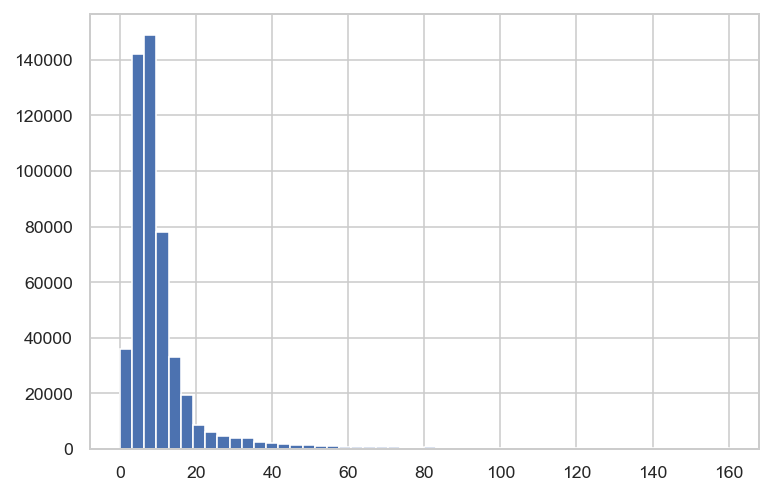

In [34]:
plt.hist(missing, bins=50) ;

Sanity check: Number of nans should match missing number for each SNP

In [35]:
(raw_data.isnull().sum(axis=1) == missing).all()

True

## African and non-African individuals

In [36]:
afr_individuals = [name for (name, data) in individuals.items() if data['Region'] == 'Africa' and data['Genetic sex assignment'] == 'XY']
nonafr_individuals = [name for (name, data) in individuals.items() if data['Region'] != 'Africa' and data['Genetic sex assignment'] == 'XY']

In [37]:
len(afr_individuals + nonafr_individuals)

162

## Subset SFS data into Africans and non-Africans

We only include sites that segregate in humans.

In [38]:
# afr_genotypes = raw_data.loc[~is_fixed_humans, afr_individuals]
# nonafr_genotypes = raw_data.loc[~is_fixed_humans, nonafr_individuals]
afr_genotypes = raw_data.loc[:, afr_individuals]
nonafr_genotypes = raw_data.loc[:, nonafr_individuals]

Compute proportion missing in each set and decide on cutoff:

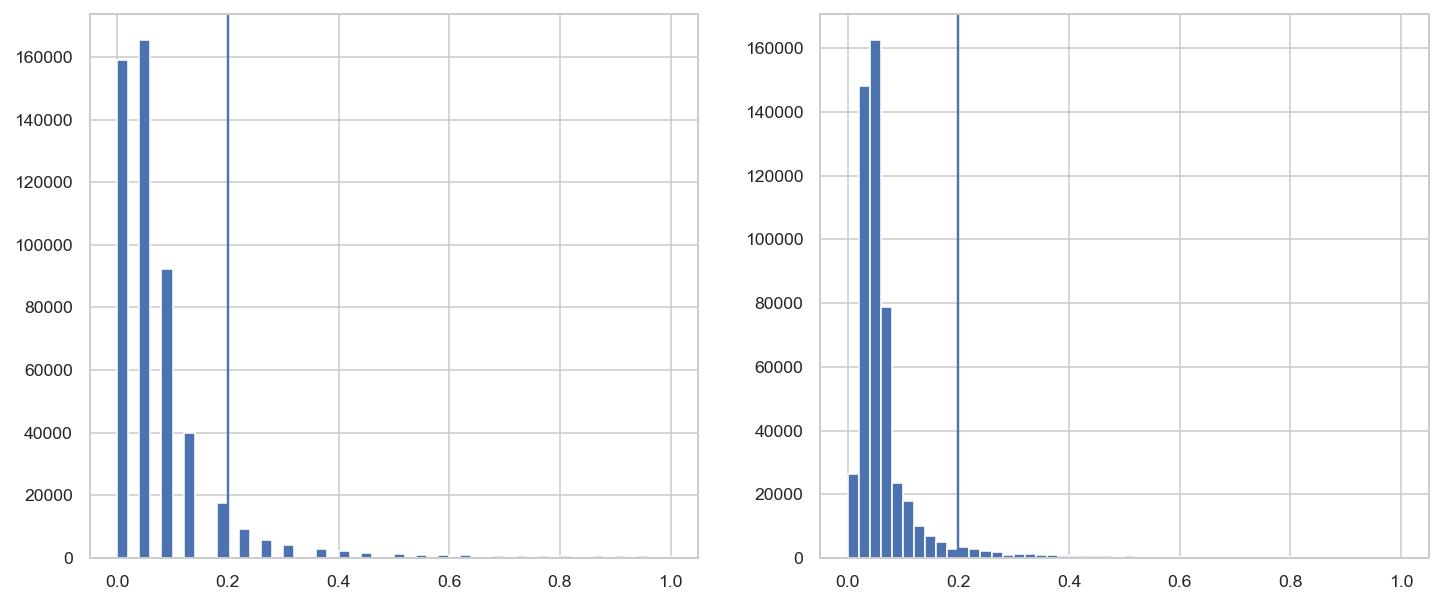

In [39]:
afr_missing = afr_genotypes.isnull().sum(axis=1) / len(afr_individuals)
nonafr_missing = nonafr_genotypes.isnull().sum(axis=1) / len(nonafr_individuals)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(afr_missing, bins=50)
ax1.axvline(x=0.2)
ax2.hist(nonafr_missing, bins=50)
ax2.axvline(x=0.2) ;

## Compute freqs for each SNP

In [40]:
afr_genotypes_filt = afr_genotypes.loc[afr_missing < 0.2]
#afr_sfs_data = afr_genotypes_filt.apply(lambda sr: sr.sum() / (~sr.isnull()).sum(), axis=1 )
afr_sfs_data = afr_genotypes_filt.apply('mean', axis=1 )
afr_sfs_data.index.name = 'pos'
afr_sfs_data.head()

pos
1254456    0.045441
2419650    0.000000
2419678    0.000000
2701632    0.000000
2701845    0.000000
dtype: float16

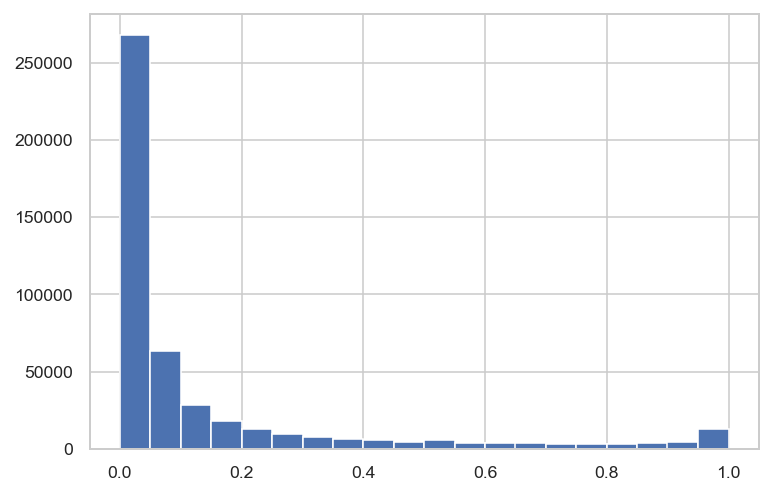

In [41]:
plt.hist(afr_sfs_data, bins=20) ;

In [42]:
nonafr_genotypes_filt = nonafr_genotypes.loc[nonafr_missing < 0.2]
# nonafr_sfs_data = nonafr_genotypes_filt.apply(lambda sr: sr.sum() / (~sr.isnull()).sum(), axis=1 )
nonafr_sfs_data = nonafr_genotypes_filt.apply('mean', axis=1 )
nonafr_sfs_data.index.name = 'pos'
nonafr_sfs_data.head()

pos
1254456    0.000000
2419158    0.000000
2419650    0.008698
2419678    0.033600
2420392    0.194702
dtype: float16

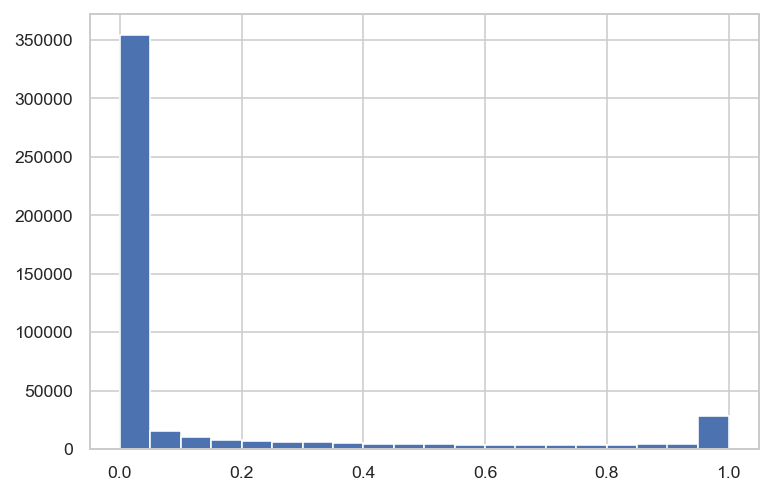

In [43]:
plt.hist(nonafr_sfs_data, bins=20) ;

In [44]:
len(afr_genotypes_filt), len(nonafr_genotypes_filt)

(473980, 482113)

## Assign nonzero sites to windows

In [45]:
afr_derived_freqs = afr_sfs_data.reset_index(name='freq')
afr_derived_freqs['start'] = afr_derived_freqs.pos // 100000 * 100000
afr_derived_freqs['end'] = afr_derived_freqs.start + 100000
afr_derived_freqs = afr_derived_freqs.loc[afr_derived_freqs.freq > 0]

nonafr_derived_freqs = nonafr_sfs_data.reset_index(name='freq')
nonafr_derived_freqs['start'] = nonafr_derived_freqs.pos // 100000 * 100000
nonafr_derived_freqs['end'] = nonafr_derived_freqs.start + 100000
nonafr_derived_freqs = nonafr_derived_freqs.loc[nonafr_derived_freqs.freq > 0]

derived_freqs = pd.concat([afr_derived_freqs.assign(region='Africa'),
                                 nonafr_derived_freqs.assign(region='nonAfrica')])
derived_freqs.head()

,pos,freq,start,end,region
0,1254456,0.045441,1200000,1300000,Africa
5,2701938,0.950195,2700000,2800000,Africa
6,2702143,0.199951,2700000,2800000,Africa
8,2702339,0.863770,2700000,2800000,Africa
9,2702698,0.181763,2700000,2800000,Africa


## Compute non-African SFS in as a function of ECH proportion in each 100kb window

In [46]:
non_afr_total_swept.head()

,index,start,end,is_non_african,nr_swept,total,pos,prop_swept
0,1,2700000,2800000,True,0,139,2750000.0,0.0
1,3,2800000,2900000,True,0,140,2850000.0,0.0
2,5,2900000,3000000,True,0,140,2950000.0,0.0
3,7,3000000,3100000,True,0,140,3050000.0,0.0
4,9,3100000,3200000,True,0,140,3150000.0,0.0


In [47]:
df = (nonafr_derived_freqs[['start', 'end', 'freq']]
 .merge(non_afr_total_swept[['start', 'end', 'prop_swept']], on=['start', 'end'], how='left')
)
df = df.loc[~df.prop_swept.isnull()]

df['ECH_freq_bin'] = pd.cut(df.prop_swept, np.linspace(0, 1, 5), include_lowest=True, 
                            labels=['No ECHs', 'ECH frequency 25-50%', 'ECH frequency 50-75%', 'ECH frequency 75-100%'])
df.head()

,start,end,freq,prop_swept,ECH_freq_bin
3,2700000,2800000,0.007519,0.0,No ECHs
4,2700000,2800000,0.008331,0.0,No ECHs
5,2700000,2800000,1.000000,0.0,No ECHs
6,2700000,2800000,0.870117,0.0,No ECHs
7,2700000,2800000,0.015152,0.0,No ECHs


In [48]:
#sns.catplot(data=df.loc[df.freq > 0.25], x="ECH_freq_bin", y="freq", kind="boxen") ;

In [49]:
#sns.catplot(data=df, x="ECH_freq_bin", y="freq", kind="boxen") ;

Full SFS:

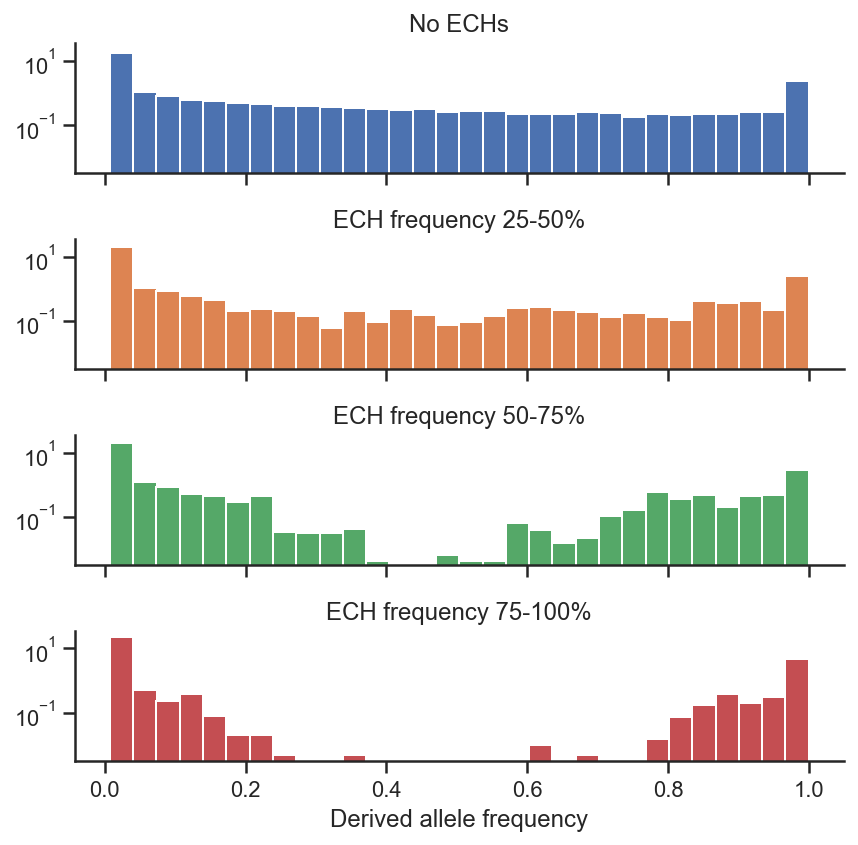

In [50]:
with sns.plotting_context('notebook'):
    with sns.axes_style("ticks"):
        g = sns.FacetGrid(data=df, row="ECH_freq_bin", hue="ECH_freq_bin", aspect=4, height=1.5)
        g.map(plt.hist, 'freq', density=True, bins=30)
        plt.xlabel('Derived allele frequency') ;
        plt.yscale('log')

        for ax in g.axes.flat:
            g.set_titles(row_template = '{row_name}')
        
        plt.savefig(str(ag.figures_dir / f'sfs_hist_by_ech_log_freq_full_{ech_calling_tag}.pdf'))         
        plt.savefig(str(ag.figures_dir / f'sfs_hist_by_ech_log_freq_full_{ech_calling_tag}.png'))         

With y-axis truncated to better show high freq alleles:

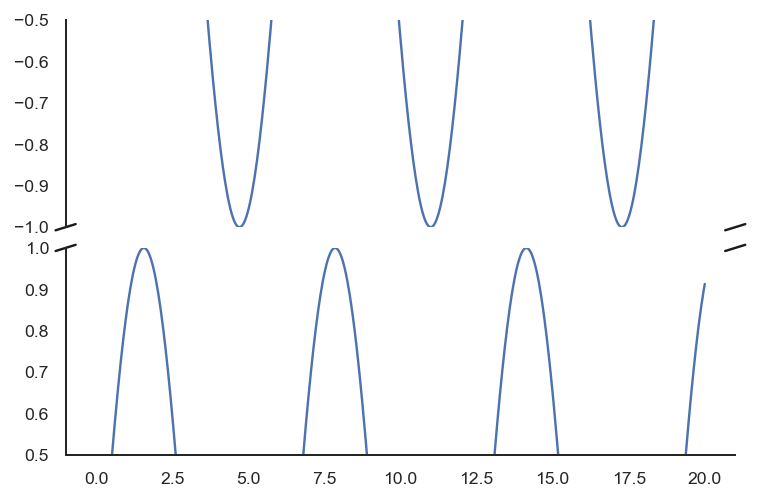

In [51]:
x = np.linspace(0, 20, 500)
y = np.sin(x)

with sns.axes_style('white'):
    f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True)
    ax = sns.lineplot(x=x, y=y, ax=ax1)
    ax = sns.lineplot(x=x, y=y, ax=ax2)

    ax1.set_ylim(-1, -0.5)
    ax2.set_ylim(0.5, 1)

    sns.despine()

    plt.subplots_adjust(wspace=0, hspace=0.1)

#    ax1.axes.xaxis.set_visible(False
#    ax1.spines['bottom'].set_visible(False)
    
    # hide the spines between ax and ax2
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.axes.xaxis.set_visible(False)

#     ax1.xaxis.tick_top()
#     ax1.tick_params(labeltop='off')  # don't put tick labels at the top
#     ax2.xaxis.tick_bottom()
#     ax1.tick_params(labeltop='off')  # don't put tick labels at the top

    
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    


In [52]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [53]:
nr_bins = 10
df_list = []
for name, group in df.groupby('ECH_freq_bin'):
    gr_df = (pd.cut(df.loc[df.ECH_freq_bin == name].freq, bins=np.linspace(0, 1, nr_bins+1))
             .to_frame()
             .groupby('freq')
             .size()
             .to_frame('counts')
             .reset_index()
            )
    gr_df['name'] = name
    gr_df['density'] = gr_df.counts / gr_df.counts.sum() / nr_bins
    df_list.append(gr_df)
plot_df = pd.concat(df_list)
plot_df.head()

,freq,counts,name,density
0,"(0.0, 0.1]",184468,No ECHs,0.064297
1,"(0.1, 0.2]",16639,No ECHs,0.005800
2,"(0.2, 0.3]",12208,No ECHs,0.004255
3,"(0.3, 0.4]",10279,No ECHs,0.003583
4,"(0.4, 0.5]",8662,No ECHs,0.003019


In [54]:
plot_df.name.unique().tolist()

['No ECHs',
 'ECH frequency 25-50%',
 'ECH frequency 50-75%',
 'ECH frequency 75-100%']

In [55]:
pal = sns.color_palette((sns.color_palette('twilight_shifted', 8)[::2]))
pal

[(0.33954168752669694, 0.1370480189671817, 0.5232879753508524),
 (0.4867359599430568, 0.6341664625110051, 0.7625578008592404),
 (0.8542921961147046, 0.7909719677709199, 0.765838014779141),
 (0.6583280801134499, 0.2780321095766563, 0.3134643447952643)]

In [57]:
cell_genomics = sns.plotting_context()

In [58]:
cell_genomics['font.size'] = 8
cell_genomics['axes.labelsize'] = 8
cell_genomics['axes.titlesize'] = 8
cell_genomics['xtick.labelsize'] = 8
cell_genomics['ytick.labelsize'] = 8
cell_genomics['legend.title_fontsize'] = 8
cell_genomics

{'font.size': 8,
 'axes.labelsize': 8,
 'axes.titlesize': 8,
 'xtick.labelsize': 8,
 'ytick.labelsize': 8,
 'legend.fontsize': 8.8,
 'axes.linewidth': 1.0,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.2000000000000002,
 'lines.markersize': 4.800000000000001,
 'patch.linewidth': 0.8,
 'xtick.major.width': 1.0,
 'ytick.major.width': 1.0,
 'xtick.minor.width': 0.8,
 'ytick.minor.width': 0.8,
 'xtick.major.size': 4.800000000000001,
 'ytick.major.size': 4.800000000000001,
 'xtick.minor.size': 3.2,
 'ytick.minor.size': 3.2,
 'legend.title_fontsize': 8}

In [61]:
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Arial"

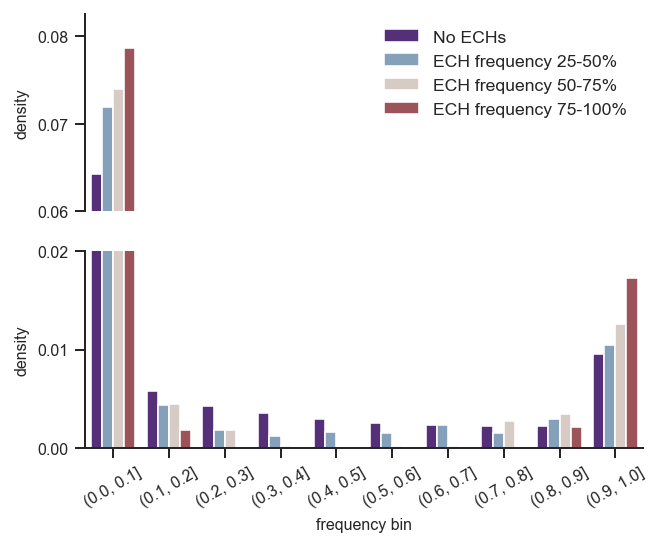

In [63]:
with sns.plotting_context(cell_genomics), sns.axes_style("ticks", {'font.family': 'Arial'}):
    with sns.color_palette(pal):
#    sns.set(font='Arial')
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 4))

        ax = sns.barplot(data=plot_df, x="freq", y="density", hue="name", ci=False, ax=ax1)
        ax1.set_xticklabels(ax.get_xticklabels(), rotation=30) 
        ax1.set_xlabel("frequency bin")
        sns.despine()

        ax = sns.barplot(data=plot_df, x="freq", y="density", hue="name", ci=False, ax=ax2)
        ax2.set_xticklabels(ax.get_xticklabels(), rotation=30) 
        ax2.set_xlabel("frequency bin")
        sns.despine()

        ax1.set_ylim(bottom=0.06)
        ax1.get_xaxis().set_visible(False)
        ax1.spines['bottom'].set_visible(False)
        ax2.set_ylim(top=0.02)

        # ax1.legend(plot_df.name.unique().tolist(), frameon=False)
        ax1.legend(*(ax1.get_legend_handles_labels()), frameon=False)
        ax2.legend([], [], frameon=False)

        plt.subplots_adjust(hspace=None)

        ax1.locator_params(axis='y', nbins=3)
        ax2.locator_params(axis='y', nbins=3)


        plt.savefig(str(ag.figures_dir / f'sfs_hist_by_ech_freq_{ech_calling_tag}.pdf'), bbox_inches='tight')         
        plt.savefig(str(ag.figures_dir / f'sfs_hist_by_ech_freq_{ech_calling_tag}.png'), bbox_inches='tight')         

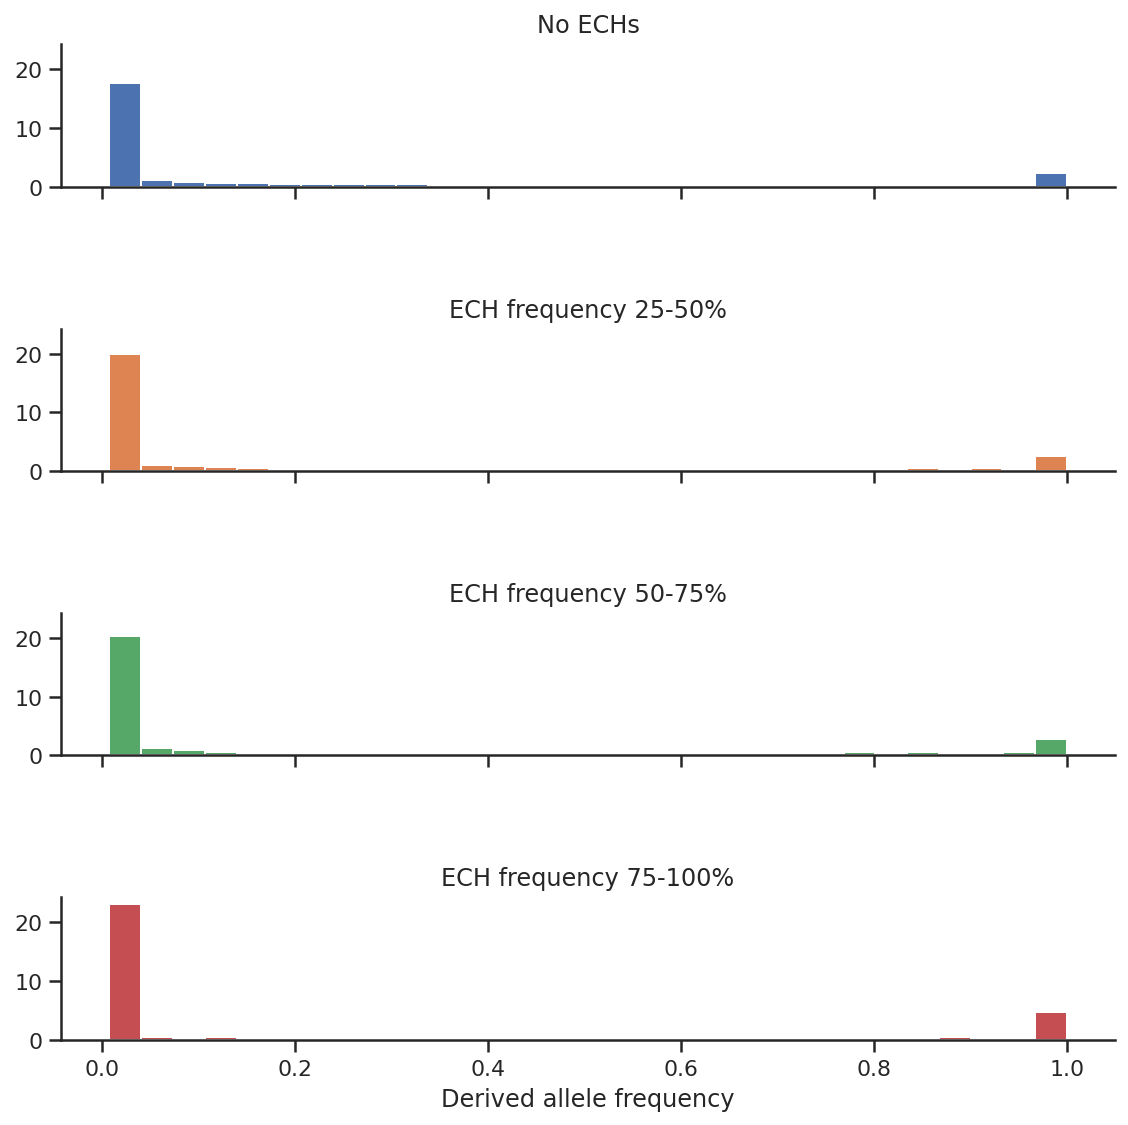

In [87]:
with sns.plotting_context('notebook'):
    with sns.axes_style("ticks"):
        g = sns.FacetGrid(data=df, row="ECH_freq_bin", hue="ECH_freq_bin", 
                          aspect=4, height=2, sharey=True)
        g.map(plt.hist, 'freq', density=True, bins=30)
        plt.xlabel('Derived allele frequency') ;

        for ax in g.axes.flat:
            g.set_titles(row_template = '{row_name}')

        plt.subplots_adjust(hspace=1.)            
            
        # plt.savefig(str(ag.figures_dir / f'sfs_hist_by_ech_freq_full_{ech_calling_tag}.pdf'))         
        # plt.savefig(str(ag.figures_dir / f'sfs_hist_by_ech_freq_full_{ech_calling_tag}.png')) 

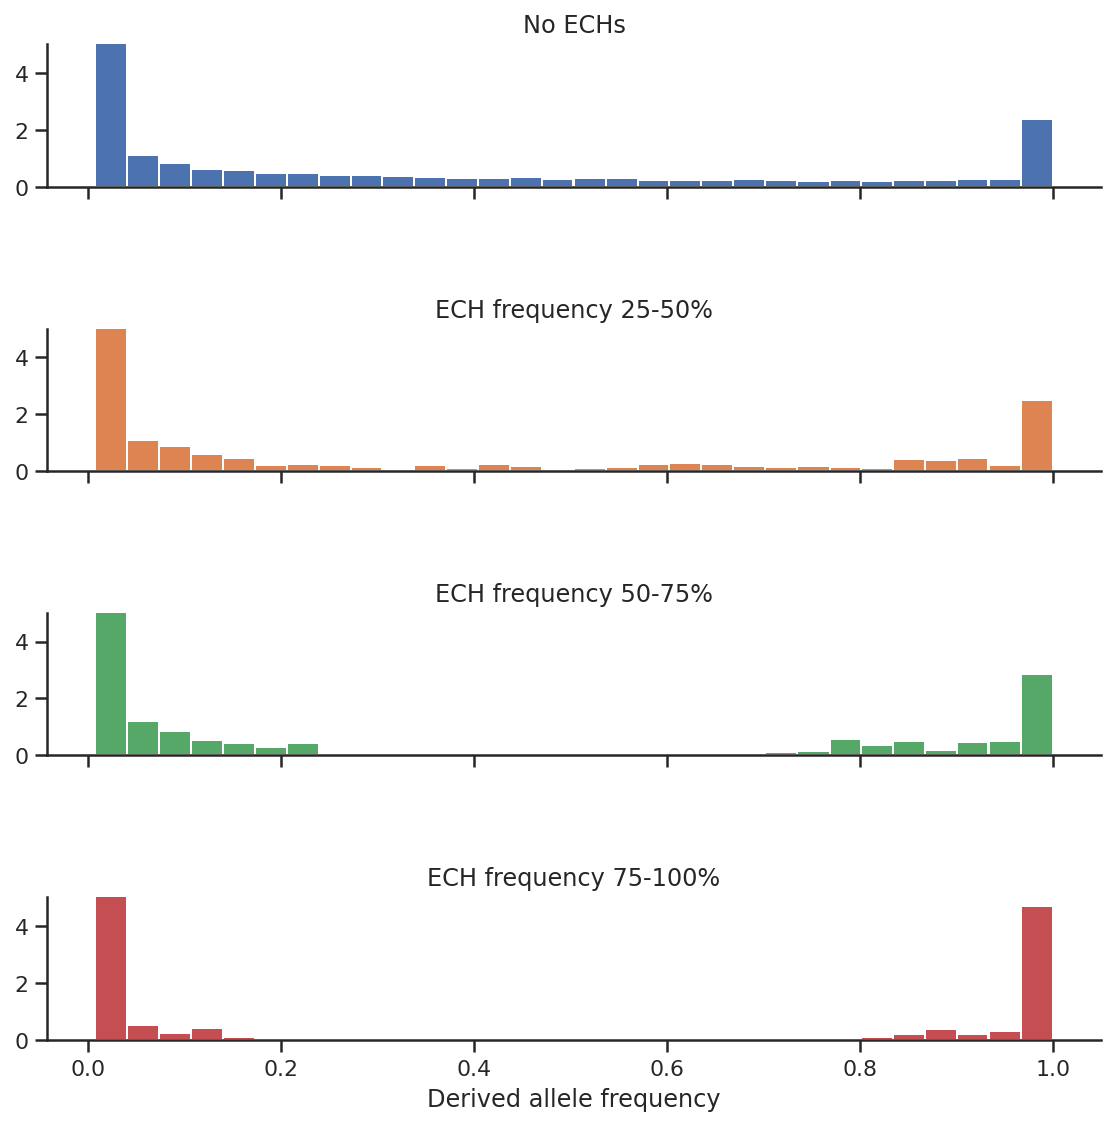

In [36]:
with sns.plotting_context('notebook'):
    with sns.axes_style("ticks"):
        g = sns.FacetGrid(data=df, row="ECH_freq_bin", hue="ECH_freq_bin", 
                          aspect=4, height=2, sharey=True)
        g.map(plt.hist, 'freq', density=True, bins=30)
        for ax in g.axes.flat:
            ax.set_ylim(top=5)
        plt.xlabel('Derived allele frequency') ;

        for ax in g.axes.flat:
            g.set_titles(row_template = '{row_name}')

        plt.subplots_adjust(hspace=1.)            

        # plt.savefig(str(ag.figures_dir / f'sfs_hist_by_ech_freq_truncated_{ech_calling_tag}.pdf'))         
        # plt.savefig(str(ag.figures_dir / f'sfs_hist_by_ech_freq_truncated_{ech_calling_tag}.png'))                 

Same thing but as violin plots:

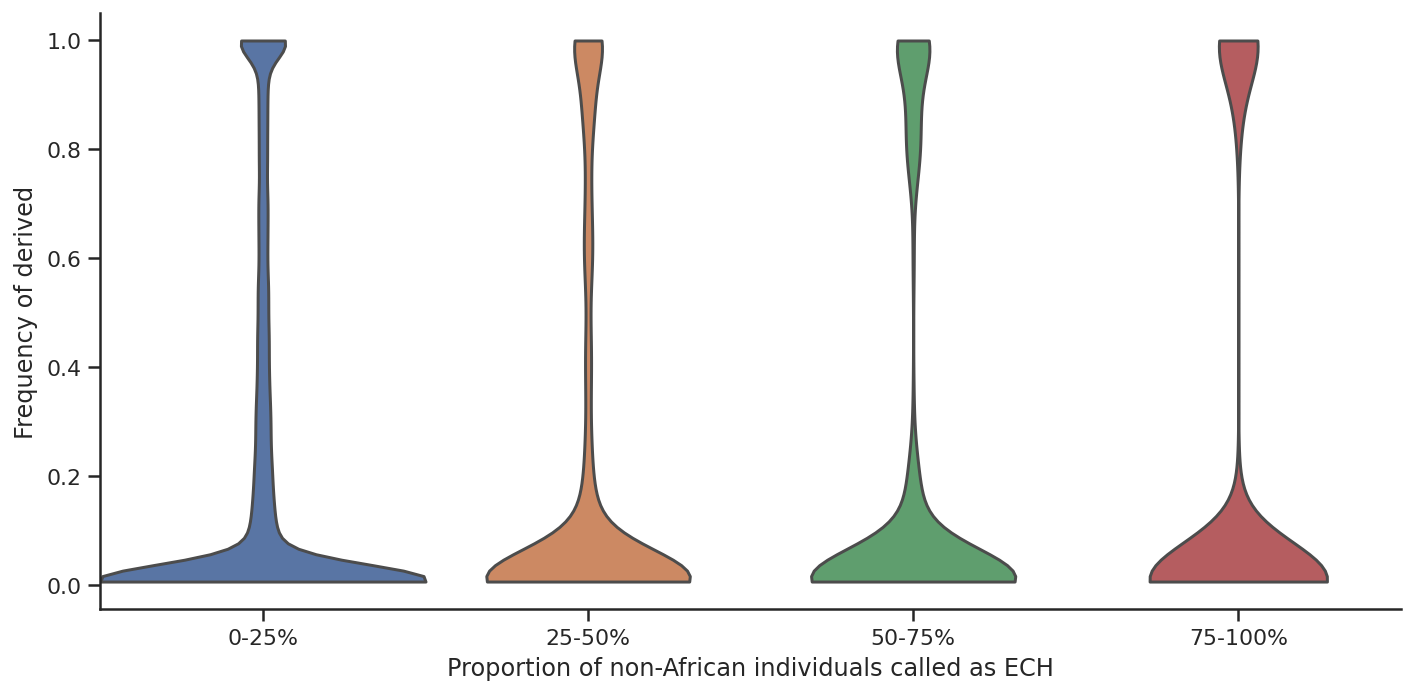

In [36]:
with sns.plotting_context('notebook'):
    with sns.axes_style("ticks"):
        g = sns.catplot(data=df, x="ECH_freq_bin", y="freq", kind="violin", 
                    cut=0, width=1, inner=None, aspect=2) 
        g.set_axis_labels("Proportion of non-African individuals called as ECH", "Frequency of derived") 
        plt.savefig(str(ag.figures_dir / f'sfs_by_ech_freq_full_{ech_calling_tag}.pdf')) 

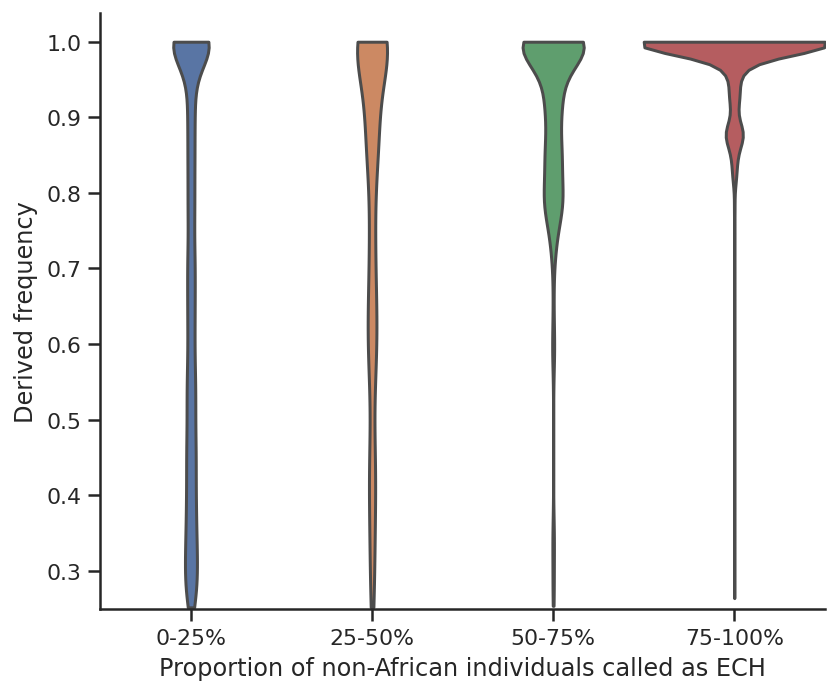

In [37]:
with sns.plotting_context('notebook', font_scale=1):
    with sns.axes_style("ticks", {'axes.grid' : False}):
        g = sns.catplot(data=df.loc[(df.freq > 0.25)], x="ECH_freq_bin", y="freq", kind="violin", 
                        cut=0, width=1, inner=None, aspect=1.2) 
        g.set(ylim=(0.25, None))
        g.set_axis_labels("Proportion of non-African individuals called as ECH", "Derived frequency")
        plt.savefig(str(ag.figures_dir / f'sfs_by_ech_freq_highonly_{ech_calling_tag}.pdf')) 

## Compute mean frequency of intermediate and high frequency derived variants in windows

We only compute mean for variants with at frequency of at least 0.25.

Corresponds to our clade size criterion when we call ECHs.

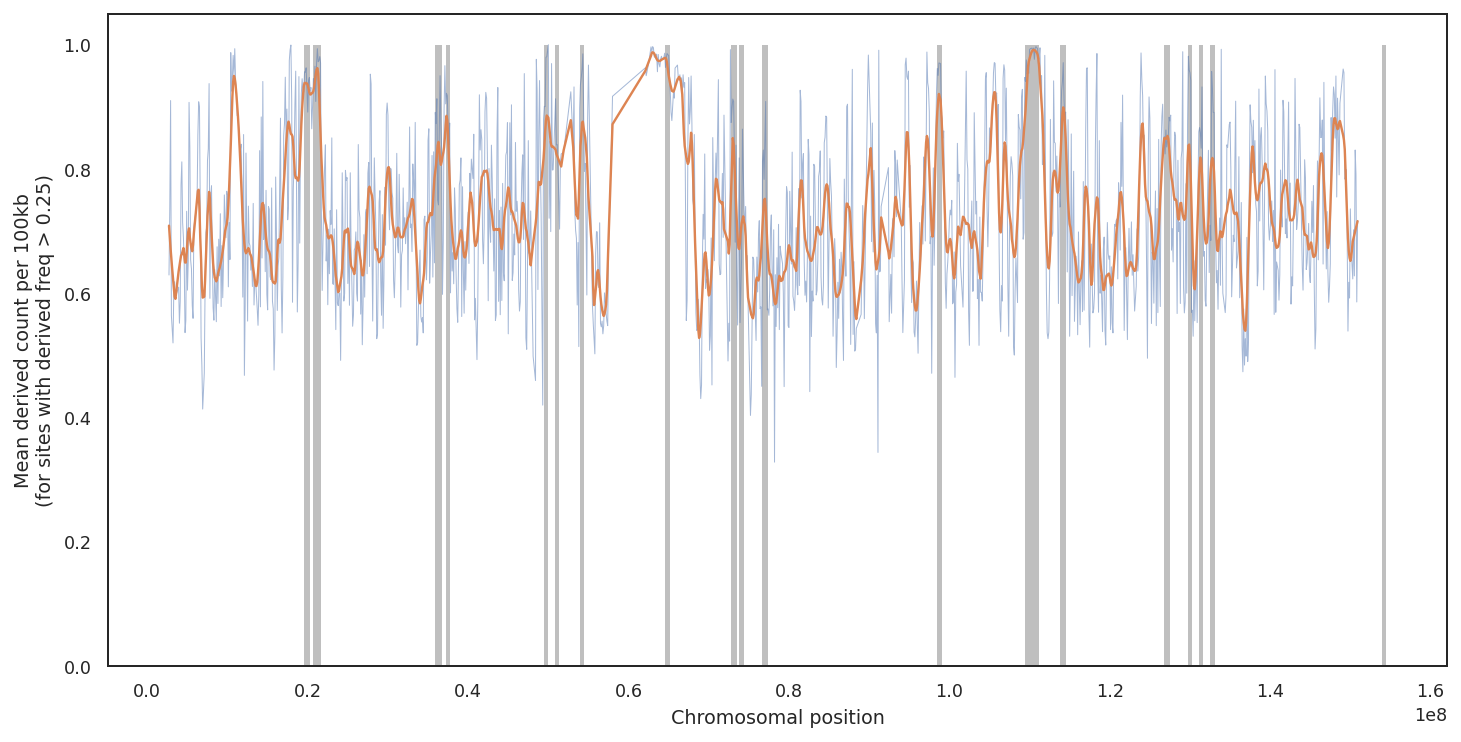

In [38]:
min_freq = 0.25
nonafr_derived_window_freqs = (derived_freqs
                        .loc[(derived_freqs.region == 'nonAfrica') & (derived_freqs.freq > min_freq)]
                        .groupby(['region', 'start', 'end'])
                        .freq
                        .agg(['mean', 'count'])
                        .reset_index()
                        .rename(columns={'mean': 'mean_freq', 'count': 'nr_snps'})
                       )
#nonafr_derived_window_freqs.head()

with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    p = ax.plot(nonafr_derived_window_freqs.start, nonafr_derived_window_freqs.mean_freq, linewidth=0.5, alpha=0.5)

    for tup in extended_peak_regions_75.itertuples():
        base = 0
        g = ax.add_patch(Rectangle((tup.start_pos, base), tup.end_pos-tup.start_pos, nonafr_derived_window_freqs.mean_freq.max()-base, 
                     facecolor='gray',
                     linewidth=0,
                     alpha=0.5,
                     zorder=0))
    ax.set_ylim(bottom=base)
        
    fit = lowess(nonafr_derived_window_freqs.mean_freq, nonafr_derived_window_freqs.start, is_sorted=True, frac=0.01, it=0)
    ax.plot(fit[:,0], fit[:,1])
        
#     ax.fill_between(plot_df.start, plot_df.mean_freq, plot_df.mean_freq.max(),
#                     interpolate=False, color=p[-1].get_color(), alpha=0.2)
    ax.set_xlabel("Chromosomal position")
    ax.set_ylabel("Mean derived count per 100kb\n(for sites with derived freq > {})".format(min_freq))

## Load sweep data

In [40]:
sweep_data = pd.read_hdf(ag.results_dir / f'sweep_data_{ech_calling_tag}.hdf').loc[lambda df: df.not_missing]

## Compute the proportion of medium and high frequency SNPs in each haplotype window where the variant is derived.

We only consider variants with a frequency of at least our cutoff:

In [41]:
min_freq = 0.25

In [42]:
df = nonafr_genotypes_filt.rename_axis('pos').reset_index().melt(id_vars='pos', var_name='indiv_1', value_name='is_derived')
df['start'] = (df.pos // 100000) * 100000
df.head()

,pos,indiv_1,is_derived,start
0,1254456,B_Karitiana-3,0.0,1200000
1,2419158,B_Karitiana-3,NaN,2400000
2,2419650,B_Karitiana-3,NaN,2400000
3,2419678,B_Karitiana-3,0.0,2400000
4,2420392,B_Karitiana-3,0.0,2400000


In [43]:
def filt(df):
    num = df.is_derived.sum()
    denom = (~df.is_derived.isnull()).sum()
    return denom > 0 and num / denom > min_freq
       
def stats(df):
    num = df.is_derived.sum()
    denom = (~df.is_derived.isnull()).sum()
    if denom > 0:
        ratio = num / denom
    else:
        ratio = np.nan
    return pd.Series([num, denom, ratio], index=['nr_derived', 'nr_total', 'prop_deriv'])
    
derived_windows = (df
            .groupby('pos')
            .filter(filt)
            .groupby(['indiv_1', 'start'])
            .apply(stats)
            .reset_index()
           )
derived_windows.head(3)

,indiv_1,start,nr_derived,nr_total,prop_deriv
0,B_Australian-4,2700000,75.0,106.0,0.707547
1,B_Australian-4,2800000,59.0,75.0,0.786667
2,B_Australian-4,2900000,28.0,28.0,1.000000


In [44]:
merged_data = derived_windows.merge(sweep_data, on=['indiv_1', 'start'], how='left')
merged_data.head(3)

,indiv_1,start,nr_derived,nr_total,prop_deriv,end,pop_1,region_label_1,region_id_1,region_1,...,swept_af,not_missing,never_swept,never_swept_af,never_win_swept,never_win_swept_af,conserv_swept_group,conserv_swept_group_af,partial_sweep_win,partial_sweep_win_af
0,B_Australian-4,2700000,75.0,106.0,0.707547,2800000.0,Australian,Oceania,4.0,Oceania,...,False,True,True,True,True,True,no,no,False,False
1,B_Australian-4,2800000,59.0,75.0,0.786667,2900000.0,Australian,Oceania,4.0,Oceania,...,False,True,True,True,True,True,no,no,False,False
2,B_Australian-4,2900000,28.0,28.0,1.000000,3000000.0,Australian,Oceania,4.0,Oceania,...,False,True,True,True,False,False,no,no,False,False


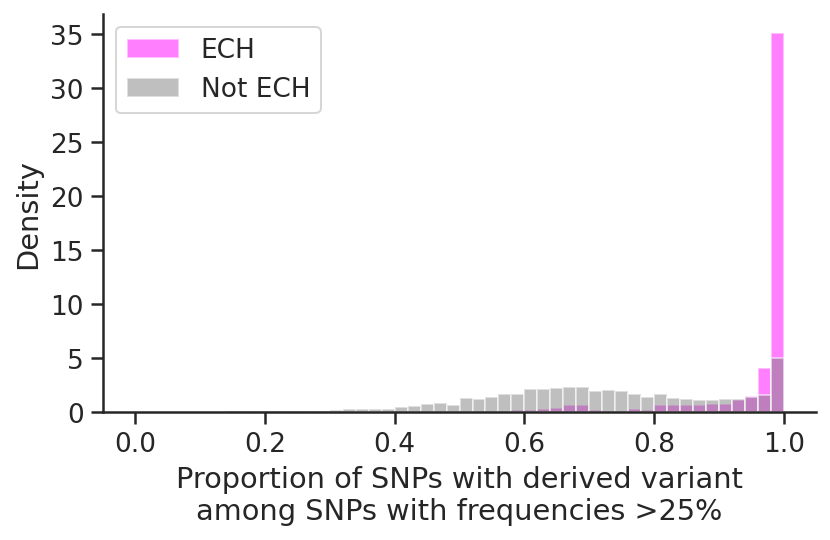

In [45]:
with sns.plotting_context('notebook', font_scale=1.2):
    with sns.axes_style("ticks", {'axes.grid' : False}):
        plt.hist(merged_data.loc[merged_data.swept == True].prop_deriv, label='ECH', facecolor='#FF01FF',
                 density=True, alpha=0.5, bins=np.linspace(0, 1, 51))
        plt.hist(merged_data.loc[merged_data.swept == False].prop_deriv, label='Not ECH', color='grey',
                 density=True, alpha=0.5, bins=np.linspace(0, 1, 51))

        plt.xlabel("Proportion of SNPs with derived variant\namong SNPs with frequencies >{}%".format(int(min_freq*100)))
        plt.ylabel('Density')
        plt.legend()
#        plt.xlim(0.25)
        sns.despine()
        plt.tight_layout()
        plt.savefig(str(ag.figures_dir / f'derived_{ech_calling_tag}.pdf')) 

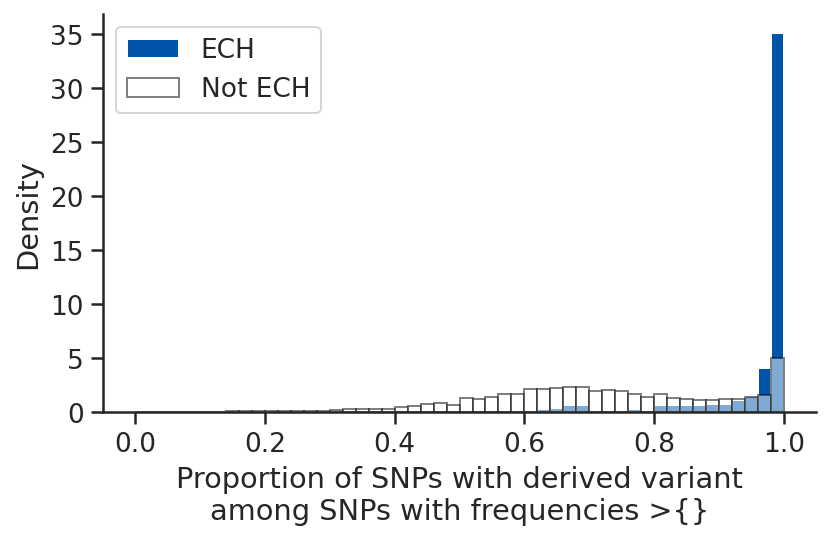

In [46]:

with sns.plotting_context('notebook', font_scale=1.2):
    with sns.axes_style("ticks", {'axes.grid' : False}):
#         plt.hist(merged_data.loc[merged_data.swept == True].prop_deriv, label='ECH', facecolor='#2901F7',
#                  density=True, alpha=0.6, bins=np.linspace(0, 1, 51))
        plt.hist(merged_data.loc[merged_data.swept == True].prop_deriv, label='ECH', facecolor='#0055AA', 
                 density=True, alpha=1, bins=np.linspace(0, 1, 51))
#         plt.hist(merged_data.loc[merged_data.swept == False].prop_deriv, label='Not ECH', facecolor="none", edgecolor='black',
#                  density=True, bins=np.linspace(0, 1, 51))
        plt.hist(merged_data.loc[merged_data.swept == False].prop_deriv, label='Not ECH', facecolor="white", 
                  edgecolor='black',
                 density=True, alpha=0.5, bins=np.linspace(0, 1, 51))

        plt.xlabel("Proportion of SNPs with derived variant\namong SNPs with frequencies >{}")
        plt.ylabel('Density')
        plt.legend()
#         plt.xlim(0.5)
#         plt.ylim(top=0.5)
        sns.despine()
        plt.tight_layout()
        plt.savefig(str(ag.figures_dir / f'derived_{ech_calling_tag}.pdf')) 

In [47]:
merged_data.groupby(['swept']).prop_deriv.agg(['mean', 'median', 'sem'])

,mean,median,sem
swept,,,
False,0.715623,0.709677,0.000454
True,0.956086,1.000000,0.000835


In [48]:
scipy.stats.mannwhitneyu(merged_data.loc[merged_data.swept == True].prop_deriv,
                         merged_data.loc[merged_data.swept == False].prop_deriv, alternative='two-sided')

MannwhitneyuResult(statistic=1954277123.5, pvalue=0.0)

## Alternative approach

Assign genotype positions to windows:

In [49]:
df = nonafr_genotypes_filt.rename_axis('pos').reset_index().melt(id_vars='pos', var_name='indiv_1', value_name='is_derived')
df['start'] = (df.pos // 100000) * 100000
df.head()

,pos,indiv_1,is_derived,start
0,1254456,B_Karitiana-3,0.0,1200000
1,2419158,B_Karitiana-3,NaN,2400000
2,2419650,B_Karitiana-3,NaN,2400000
3,2419678,B_Karitiana-3,0.0,2400000
4,2420392,B_Karitiana-3,0.0,2400000


In [50]:
df = df.loc[~df.is_derived.isnull()]
df.head()

,pos,indiv_1,is_derived,start
0,1254456,B_Karitiana-3,0.0,1200000
3,2419678,B_Karitiana-3,0.0,2400000
4,2420392,B_Karitiana-3,0.0,2400000
5,2701632,B_Karitiana-3,0.0,2700000
6,2701845,B_Karitiana-3,0.0,2700000


In [51]:
df['derived_freq'] = df.groupby('pos').is_derived.transform('mean')
df['derived_freq_bin'] = pd.cut(df.derived_freq, bins=[0, 0.25, 0.5, 0.75, 1])
df['prop_derived'] = df.groupby(['indiv_1', 'start']).is_derived.transform('mean')
df.head()

,pos,indiv_1,is_derived,start,derived_freq,derived_freq_bin,prop_derived
0,1254456,B_Karitiana-3,0.0,1200000,0.000000,NaN,0.000000
3,2419678,B_Karitiana-3,0.0,2400000,0.033600,"(0.0, 0.25]",0.000000
4,2420392,B_Karitiana-3,0.0,2400000,0.194702,"(0.0, 0.25]",0.000000
5,2701632,B_Karitiana-3,0.0,2700000,0.007519,"(0.0, 0.25]",0.213867
6,2701845,B_Karitiana-3,0.0,2700000,0.008331,"(0.0, 0.25]",0.213867


In [52]:
merged_data = df.merge(sweep_data[['indiv_1', 'start', 'swept']], on=['indiv_1', 'start'], how='left')
merged_data.head()

,pos,indiv_1,is_derived,start,derived_freq,derived_freq_bin,prop_derived,swept
0,1254456,B_Karitiana-3,0.0,1200000,0.000000,NaN,0.000000,NaN
1,2419678,B_Karitiana-3,0.0,2400000,0.033600,"(0.0, 0.25]",0.000000,NaN
2,2420392,B_Karitiana-3,0.0,2400000,0.194702,"(0.0, 0.25]",0.000000,NaN
3,2701632,B_Karitiana-3,0.0,2700000,0.007519,"(0.0, 0.25]",0.213867,False
4,2701845,B_Karitiana-3,0.0,2700000,0.008331,"(0.0, 0.25]",0.213867,False


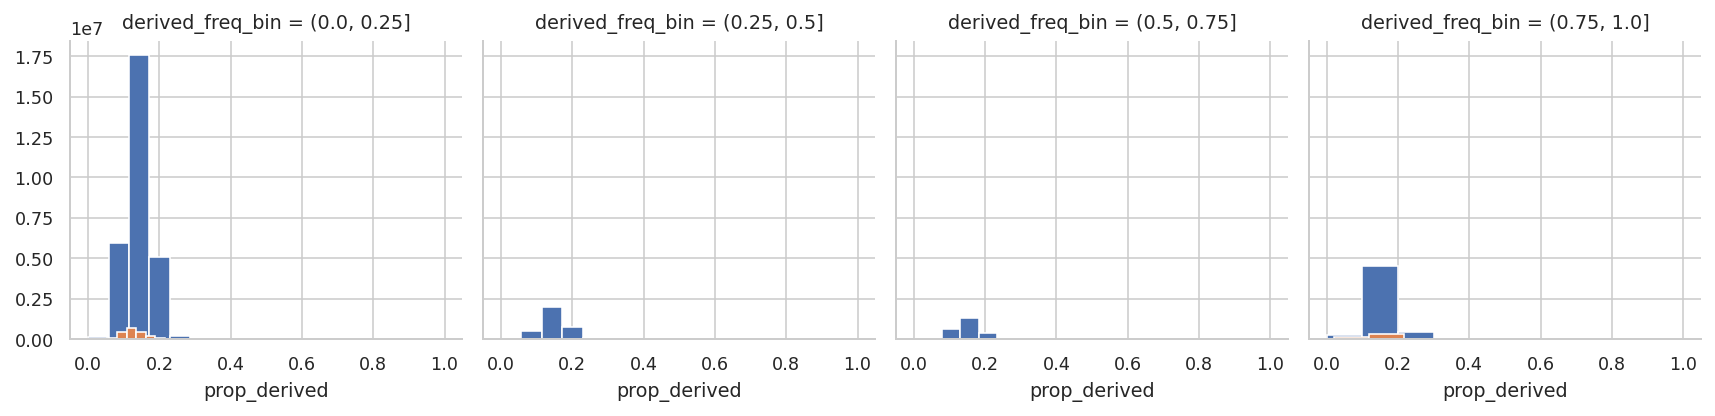

In [53]:
g = sns.FacetGrid(data=merged_data, col='derived_freq_bin', hue='swept')
g.map(plt.hist, 'prop_derived')

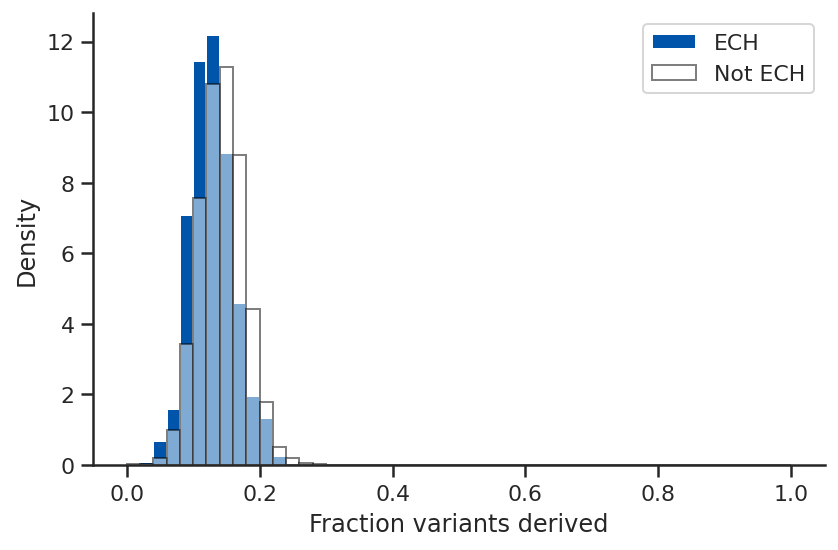

In [54]:
with sns.plotting_context('notebook', font_scale=1):
    with sns.axes_style("ticks", {'axes.grid' : False}):
        plt.hist(merged_data.loc[merged_data.swept == True].prop_derived, label='ECH', facecolor='#0055AA', 
                 density=True, alpha=1, bins=np.linspace(0, 1, 51))
        plt.hist(merged_data.loc[merged_data.swept == False].prop_derived, label='Not ECH', facecolor="white", 
                  edgecolor='black',
                 density=True, alpha=0.5, bins=np.linspace(0, 1, 51))

        plt.xlabel("Fraction variants derived")
        plt.ylabel('Density')
        plt.legend()
#        plt.xlim(right=0.5)
#         plt.ylim(top=0.5)
        sns.despine()
        plt.tight_layout()
        plt.savefig(str(ag.figures_dir / f'derived_{ech_calling_tag}.pdf')) 

That makes sense. If ECH clade MRCA is recent then most mutations will land elsewhere in the tree.

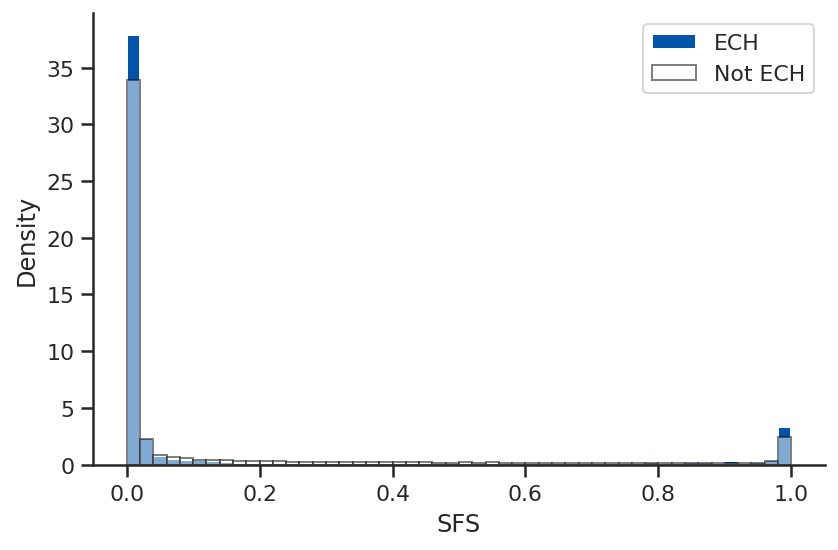

In [55]:
with sns.plotting_context('notebook', font_scale=1):
    with sns.axes_style("ticks", {'axes.grid' : False}):
#         plt.hist(merged_data.loc[merged_data.swept == True].prop_deriv, label='ECH', facecolor='#2901F7',
#                  density=True, alpha=0.6, bins=np.linspace(0, 1, 51))
        plt.hist(merged_data.loc[merged_data.swept == True].derived_freq, label='ECH', facecolor='#0055AA', 
                 density=True, alpha=1, bins=np.linspace(0, 1, 51))
#         plt.hist(merged_data.loc[merged_data.swept == False].prop_deriv, label='Not ECH', facecolor="none", edgecolor='black',
#                  density=True, bins=np.linspace(0, 1, 51))
        plt.hist(merged_data.loc[merged_data.swept == False].derived_freq, label='Not ECH', facecolor="white", 
                  edgecolor='black',
                 density=True, alpha=0.5, bins=np.linspace(0, 1, 51))

        plt.xlabel("SFS")
        plt.ylabel('Density')
        plt.legend()
#        plt.xlim(right=0.5)
#         plt.ylim(top=0.5)
        sns.despine()
        plt.tight_layout()
        plt.savefig(str(ag.figures_dir / f'derived_{ech_calling_tag}.pdf')) 